In [1]:
from __future__ import division

import re
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import qgrid

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

# Configurations
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
plt.style.use('fivethirtyeight')
reload(sys)
sys.setdefaultencoding("utf-8")
qgrid.nbinstall(overwrite=True)

# This [post](https://eddiewharton.com/2016/05/27/south-park "Post") explains the following exploration of South Park in more detail.

In [2]:
# Data source: https://github.com/BobAdamsEE/SouthParkData
# Includes all south park dialogue from the first episode to the 9th episode of the 18th season
sp = pd.read_csv('data/all-seasons.csv',encoding='latin1')

# Scraped from http://www.imdb.com/list/ls008123404/?start=1&view=compact&sort=user_rating:desc&defaults=1&scb=0.4095939879637156
imdb = pd.read_csv('data/imdb_clean.csv')


In [3]:
# Some string cleaning
sp.character = sp.character.str.replace('Mr ', 'Mr. ')
sp.character = sp.character.str.replace('Mrs ', 'Mrs. ')
sp.character = sp.character.str.replace(':|,|;','')

In [4]:
sp.head(4)

,season,episode,character,line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Sta,Forever.\n
3,10,1,Chef,I'm sorry boys.\n


In [5]:
imdb.head()

,episode_title,rating,number_of_votes,season,episode,is_multi_part_episode
0,Cartman Gets an Anal Probe,8.3,2026,1,1,False
1,Weight Gain 4000,8.0,1580,1,2,False
2,Volcano,8.0,1480,1,3,False
3,Big Gay Al's Big Gay Boat Ride,7.8,1443,1,4,False
4,An Elephant Makes Love to a Pig,7.8,1347,1,5,False


In [6]:
# Sort by season and episode and then add episode numbers
imdb.sort_values(['season','episode'],inplace=True)
imdb['episode_number']=range(1,len(imdb)+1)


In [7]:
# Remove rows that are a repetition of the column headers
sp = sp[sp.season!='Season']

# Convert season and episode to int dtype
sp.season = sp.season.astype(int)
sp.episode = sp.episode.astype(int)

sp.sort_values(['season','episode'],inplace=True)

In [8]:
# Determine the epsiode number for each episode 
episode_key = sp.groupby(['season','episode'],as_index=False)['line'].count()
episode_key['episode_number']=range(1,len(episode_key.line)+1)
sp = sp.merge(episode_key[['season','episode','episode_number']],on=['season','episode'],how='left')

In [9]:
# Join the IMDB ratings data with the text data.
# Note that this drops season 19 and the last episode of season 18 from IMDB as 
# neither are in the transcript data.
sp = sp.merge(imdb[['episode_number','episode_title','rating','number_of_votes']],on='episode_number',how='left')

# Words Predictive a Character is Talking: Classifying for Fun

In [10]:
# min_df is set to 75 in order to drop words that were frequently said, but only in an epsiode or two i.e. to reduce some overfitting 
# Feel free to lower the min_df and you might see funny reminders of memorable episodes for you favorite character
vec = TfidfVectorizer(ngram_range=[1,3],min_df=75,stop_words='english',encoding='latin1')
X_words = vec.fit_transform(sp.line)

In [11]:
# This list included main character and minor ones that had funny / distinctive words
characters_to_predict = ['Randy','Cartman','Chef','Butters','Kanye','Coon','Kyle',
                         'Mr. Garrison','Stan','Satan','Jimbo','Kenny','Jesus','Towelie']

def generate_character_words(sp,characters_to_predict,X_words,include_coef=False):
    '''
    Generates a list of words predictive that a charater is speaking. 
    '''
    character_words= pd.DataFrame()
    for character in characters_to_predict:
        y = sp.character==character
        # This is optimized to be funny, not to generalize well (hence no cross validation). Simply, other regularizations 
        # weren't as funny and L1 was too sparse for minor characters.
        model = LogisticRegression(penalty='l2')
        model_words = model.fit(X_words,y)
        
        # Build a vocabularly of features and sort by coeffiencient size
        vocab = pd.DataFrame( zip(model_words.coef_[0],vec.get_feature_names()))
        vocab.columns=['coef_%s' %character,character]
        vocab = vocab.sort_values('coef_%s' %character,ascending=False).reset_index(drop=True)
        
        # Add the regression coeficients for each character if include_coef is True
        output_cols = [character]
        if include_coef:
            output_cols.append('coef_%s' %character)
        character_words = pd.concat([character_words,vocab[output_cols]],axis=1)
    return character_words

In [12]:
# Examine characters' predictive words and their coefficients to check for signs of multicolinearity. 
# Here, that looks like words I expect to co-occur having opposite signs for the coefficents. This has been tuned to minimize that.

# Also notice that unpredictive words are similar across charatcers. 
# Stan says 'Dude' a lot and other don't. The negative words that are names shows which characters never interact,
# but it's not funny enough to put in the blog post.
generate_character_words(sp,characters_to_predict,X_words=X_words,include_coef=True)

,Randy,coef_Randy,Cartman,coef_Cartman,Chef,coef_Chef,Butters,coef_Butters,Kanye,coef_Kanye,...,Satan,coef_Satan,Jimbo,coef_Jimbo,Kenny,coef_Kenny,Jesus,coef_Jesus,Towelie,coef_Towelie
0,sharon,6.918450,eric cartman,3.633438,children,6.658899,fellas,4.966344,fish,4.694664,...,chris,6.625084,ned,8.484367,woohoo,3.701766,santa,3.372366,towel,5.808187
1,stanley,3.333456,jew,3.154802,women,2.582803,wuh,3.178924,yo,2.747993,...,party,2.726298,mayor,2.554416,fuck,2.910162,father,3.036128,high,5.598276
2,stan,3.286440,jews,3.099761,doctor,2.547535,eric,2.840341,gay,2.706878,...,heaven,2.380457,shoot,2.525339,fucking,2.788043,son,2.509328,goin,2.951870
3,shelly,3.240784,guys,3.071854,goin,2.445971,nothin,2.643306,hold,1.793065,...,god,2.079355,war,2.407574,fuckin,2.706766,air,2.144960,bring,2.787049
4,gerald,2.954556,ey,2.915596,pip,2.399574,uh,2.616671,yes,1.677085,...,just,1.710421,cows,2.193652,stick,2.474726,tonight,2.097227,forget,1.975591
5,son,2.609422,kyle,2.840088,black,2.281597,ah,2.529697,love,1.521341,...,bye,1.641789,history,2.145191,uh huh,2.426816,best,2.082025,asshole,1.890092
6,internet,2.395177,son bitch,2.601366,doin,2.232584,lady,2.043447,sorry,1.497767,...,need,1.524842,holy,2.081541,hey guys,1.999183,super,2.065301,oh man,1.786143
7,muhammad,2.074662,scott,2.600154,bad,2.221216,dad,1.884697,alright,1.407576,...,hi,1.515082,randy,2.048091,awesome,1.866178,evil,1.988187,wait,1.618401
8,drive,1.924562,mom,2.591050,damn,2.182186,grandma,1.864462,fun,1.061171,...,night,1.365810,gun,1.964039,ow,1.713786,muhammad,1.908393,don,1.553531
9,music,1.916575,token,2.571701,sexual,2.075511,mom dad,1.860146,em,0.898583,...,know,1.248070,men,1.937802,don know,1.598449,eyes,1.859187,maybe,1.393345


In [13]:
# Output characters' predictive words without coefficients to excel for formatting
character_words = generate_character_words(sp,characters_to_predict,X_words,include_coef=False)
character_words.head(20).to_excel('output_tables/south park character words.xlsx')

# Character Statistics: Kanye Is Almost as Narcissistic as Satan. The Announcer is less Narcissistic than Jesus. 

In [14]:
def make_text_features(df,col,inplace=False):
    '''
    Calculates generates features on a text column and appends features to original dataframe.
    '''
    if inplace:
        frame=df
    else:
        frame=df.copy()
    frame[col] = frame[col].fillna(' ')
    frame['number_of_words'] = frame[col].map(lambda x: len(x.split()))
    frame['number_of_characters'] = frame[col].map(lambda x: len(x))
    
    # The first str.replace removes punctuation and numbers. The second str.replace change new line characters to spaces.
    frame['clean_text'] = frame[col].str.replace('[\!|\?|\.|\,|\'|\"]',"").str.replace('\n+\r*',' ').fillna(' ')
    
    # For lambda function:
    #   Numerator is length of the words after removing word delimiters
    #   Denominator is the number of words. To avoid dividing by zero errors there is a max(1,_) 
    frame['mean_word_length'] = frame.clean_text.map(lambda x: len(''.join(x.split()))/ max(1,len(x.split())))
    
    # Finds the length of the longest word in the line
    frame['length_longest_word'] = frame.clean_text.map(lambda x: len(max(x.split(),key=len)))    
    
    # Counts number of self referential words as this can be used as an informal measure of narcissism
    frame['count_self_references'] = frame[col].str.findall('(i |me|my|mine|i\'m|i\'ll)', re.IGNORECASE).map(len)
    return frame

sp = make_text_features(sp,'line')

In [15]:
def central_characters(sp,n=20):
    '''
    Returns a list of the top n characters who have the most lines.
    '''
    characters = sp.groupby('character',as_index=False).count().sort_values('line',ascending=False).head(n)
    characters = characters.character.tolist()
    return characters


In [16]:
# Dataframe of the count of each times each characters had an epsiode's final line
last_lines = sp.groupby(['episode_number','season'],as_index=False)[['character','line']].last()

# Determine if a line is an n_word monogogue
n_word_monologue = 30
sp['is_monologue'] = sp.number_of_words> n_word_monologue

# Calculate a number of self explanatory statistics for each character
character_stats = sp.groupby('character').sum()[['number_of_words','count_self_references']]
character_stats['percent_of_words_that_refer_to_self'] = (character_stats.count_self_references / character_stats.number_of_words).round(4)*100
character_stats['percent_of_lines'] = (sp.groupby('character').count()[['line']] / len(sp)).round(4)* 100
character_stats['percent_of_words'] = (sp.groupby('character').sum()[['number_of_words']] / sp.number_of_words.sum()).round(4)*100
character_stats['final_episode_lines'] = last_lines.groupby(['character'])[['line']].count()
character_stats['mean_words_per_line'] = sp.groupby('character')[['number_of_words']].mean()
character_stats['mean_word_length'] = sp.groupby('character')[['mean_word_length']].mean()
character_stats['count_of_%s_word_monologues' %n_word_monologue] = sp.groupby('character')[['is_monologue']].sum()


In [17]:
# Top 20 character by lines
central_characters_lst = central_characters(sp,20)

# Add in the additional characters from the predictive words for fun
central_characters_lst.extend(characters_to_predict)

character_stats[character_stats.index.isin(central_characters_lst)].fillna(0)[[
        'percent_of_lines','mean_words_per_line','mean_word_length','count_of_30_word_monologues'
        ,'final_episode_lines','percent_of_words_that_refer_to_self']].to_excel('output_tables/Character Stats.xlsx')

In [18]:
# Thanks to Quantopian's qgrid package, you can sort and filter these stats interactively
qgrid.show_grid(character_stats[character_stats.index.isin(central_characters_lst)])

# (Cosine) Similarity between Characters



In [19]:
character_stats['all_text'] = sp.groupby('character')[['clean_text']].agg(lambda x: " ".join(x.tolist()))
character_stats['unqiue_words'] = character_stats.all_text.str.lower().map(lambda x: len(set(x.split())))

# Characters have very different total words spoken. Therfore, unique words as a percent of all words 
# is an unreliable measure of lexical density. Yule's K handles this problem 
# better. Can anyone suggest a python implentation of Yule's K?
character_stats['naive_lexical_density'] = character_stats['unqiue_words'] / character_stats.number_of_words

In [20]:
# Build a tfidf vector for each character's vocabulary
character_vectorizer = TfidfVectorizer(ngram_range=[1,1],min_df=75,stop_words='english',encoding='latin1')
character_tfidf = character_vectorizer.fit_transform(character_stats.all_text)

In [21]:
# Calculate the cosine similarity between the tfidf vectors for each character's vocabularly 
character_similarity = pd.DataFrame(cosine_similarity(character_tfidf))

# Add the characters name to both axes
character_similarity.columns = character_stats.index
character_similarity.index = character_stats.index

In [22]:
character_similarity['Chef'].order(ascending=False).head(7)

character
Chef                1.000000
Mr. Garrison        0.762120
Ms. Choksondik      0.748067
Kid's Mom           0.740837
Dr. Adams           0.666940
Darth Chef          0.644044
African-American    0.616642
Name: Chef, dtype: float64

This is really cool. The characters similar to chef are other teachers. They also include Darth Chef who I had forgotten about.

In [23]:
character_similarity['Randy'].order(ascending=False).head(3)

character
Randy     1.000000
Sharon    0.879156
Wendy     0.843131
Name: Randy, dtype: float64

Sharon is Randy's wife. Wendy is Randy's son's (Stan) girlfriend. Their relationship with Stan likely causes them to have similar vocabularly. 

In [24]:
character_similarity['Mr. Garrison'].order(ascending=False).head(6)

character
Mr. Garrison          1.000000
Mrs. Garrison         0.765445
Chef                  0.762120
Ms. Choksondik        0.742036
Principal Victoria    0.732451
Mr. Mackey            0.729485
Name: Mr. Garrison, dtype: float64

In [25]:
character_similarity['Phillip'].order(ascending=False).head(2)

character
Phillip     1.000000
Terrance    0.774678
Name: Phillip, dtype: float64

Terrance is Phillip's co-star on their show.

# Changes in Dialogue

In [26]:
# Count of lines per episode
lines_by_episode  = sp.groupby(['episode_number','season','episode'],as_index=False).count()[['episode_number','line']]

# Unique number of charatcers per epsiode
characters_by_episode = sp.groupby(['episode_number','season','episode'],as_index=False).agg(lambda x: x.nunique())[['episode_number','character','season']]

# Average words per line for each episode
mean_words_per_line_by_episode = sp.groupby('episode_number',as_index=False).mean()[['episode_number','number_of_words']]

# Total words per episode
total_words_by_episode = sp.groupby('episode_number',as_index=False).sum()[['episode_number','number_of_words']]

In [27]:
min_episode_number = sp.episode_number.min()
max_episode_number = sp.episode_number.max()

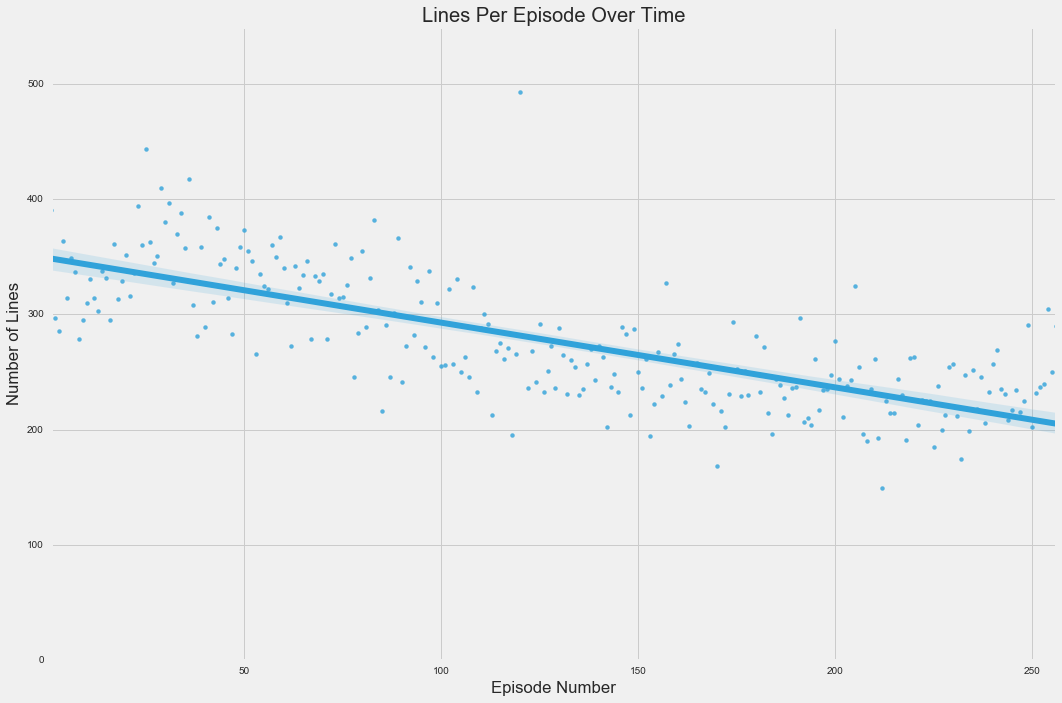

In [28]:
sns.regplot(x="episode_number", y="line", data=lines_by_episode,fit_reg=True)
plt.xlabel("Episode Number")
plt.xlim(min_episode_number,max_episode_number)
plt.ylim(0,550)
plt.ylabel("Number of Lines")
plt.title("Lines Per Episode Over Time")
plt.tight_layout()
plt.savefig("plots/Lines Per Episode.png")

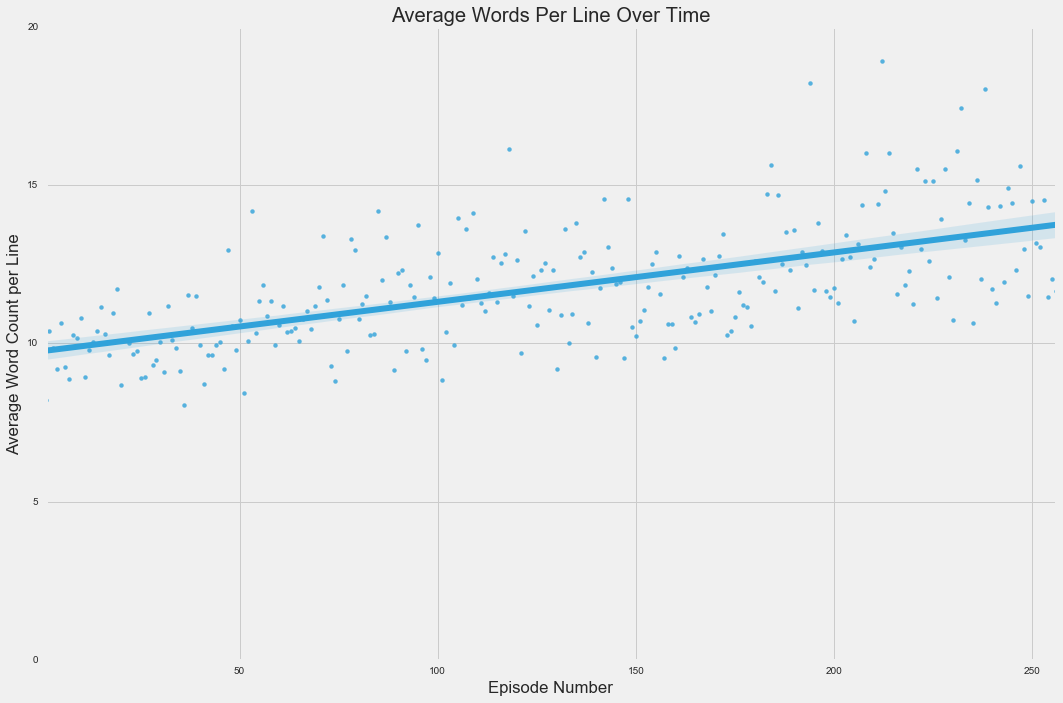

In [29]:
sns.regplot(x="episode_number", y="number_of_words", data=mean_words_per_line_by_episode)
plt.xlabel("Episode Number")
plt.xlim(min_episode_number,max_episode_number)
plt.ylim(0,20)
plt.ylabel("Average Word Count per Line")
plt.title("Average Words Per Line Over Time")
plt.tight_layout()
plt.savefig('plots/Mean Words per Line.png')

# The Rise and Fall of Jokes

In [42]:
# All of the times someone said "learned something"
sp['learned_something']= sp.line.str.contains('learned something',case=False)

# All of the times someone said "killed kenny"
sp['killed_kenny']= sp.line.str.contains('killed kenny',case=False)

# All of the times Linda or Stephen (Butters' parents) said "grounded"
sp['grounded']= (sp.line.str.contains('ground',case=False))&(sp.character.isin(["Stephen","Linda"]))

In [43]:
# The characters who say "killed kenny" the most 
sp.groupby('character').sum()['killed_kenny'].order(asending=False).tail(5)

character
Stuart      1.0
Michael     1.0
Cartman     3.0
Kyle       12.0
Stan       43.0
Name: killed_kenny, dtype: float64

In [2]:
# The characters who say "learned something" the most 
sp.groupby('character').sum()['learned_something'].order(asending=False).tail(5)

NameError: name 'sp' is not defined

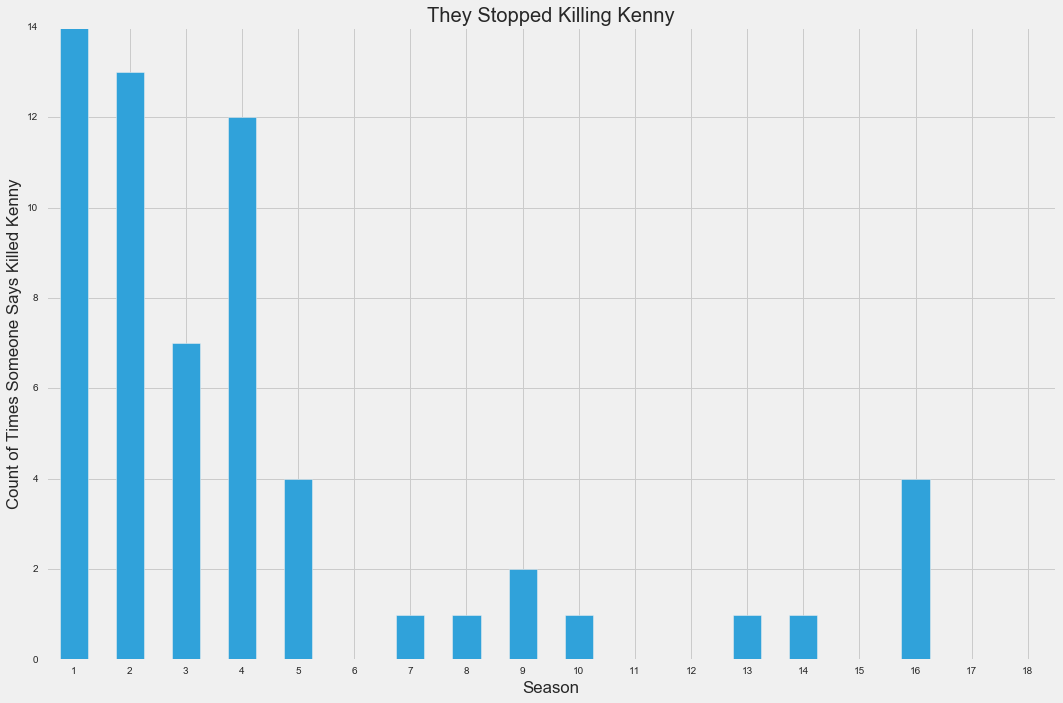

In [52]:
sp.groupby(['season'])['killed_kenny'].sum().plot(kind='bar')
plt.title("They Stopped Killing Kenny")
plt.ylabel("Count of Times Someone Says Killed Kenny")
plt.xlabel("Season")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('plots/Killed Kenny.png')

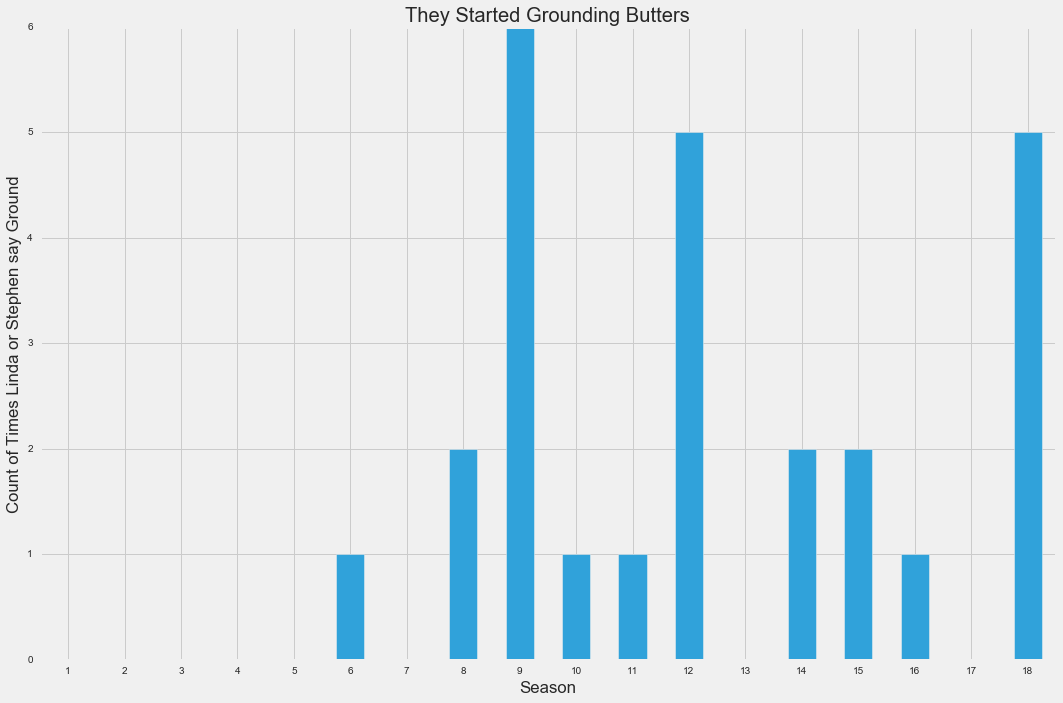

In [47]:
sp.groupby(['season'])['grounded'].sum().plot(kind='bar')
plt.title("They Started Grounding Butters")
plt.ylabel("Count of Times Linda or Stephen say Ground")
plt.xlabel("Season")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('plots/Grounded Butters.png')

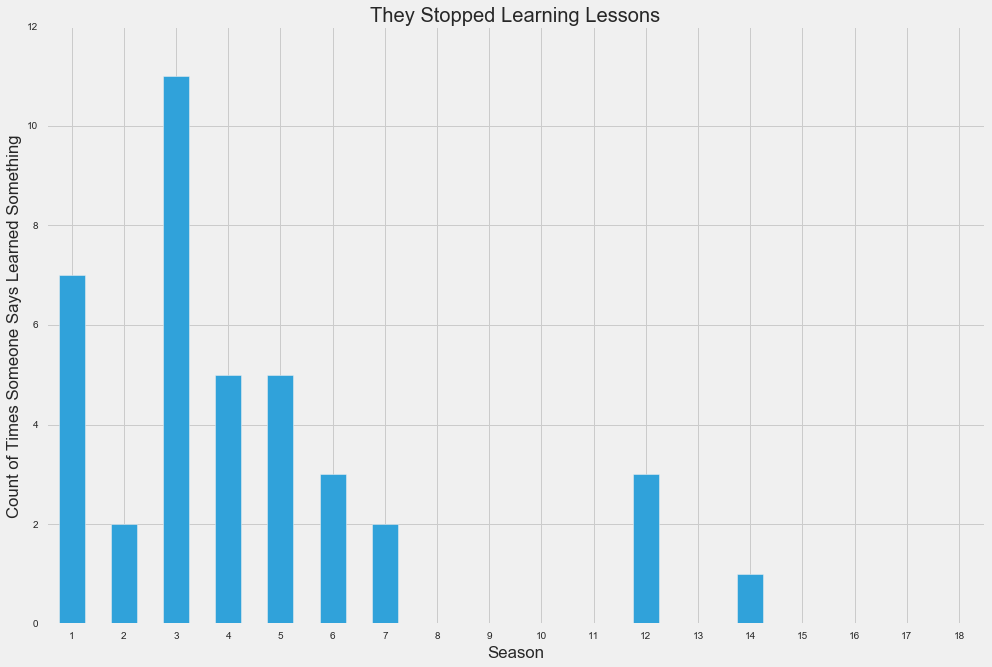

In [48]:
sp.groupby(['season'])['learned_something'].sum().plot(kind='bar')
plt.title("They Stopped Learning Lessons")
plt.ylabel("Count of Times Someone Says Learned Something")
plt.xlabel("Season")
plt.xticks(rotation=0)
# plt.tight_layout()
plt.savefig('plots/Learned Something.png')

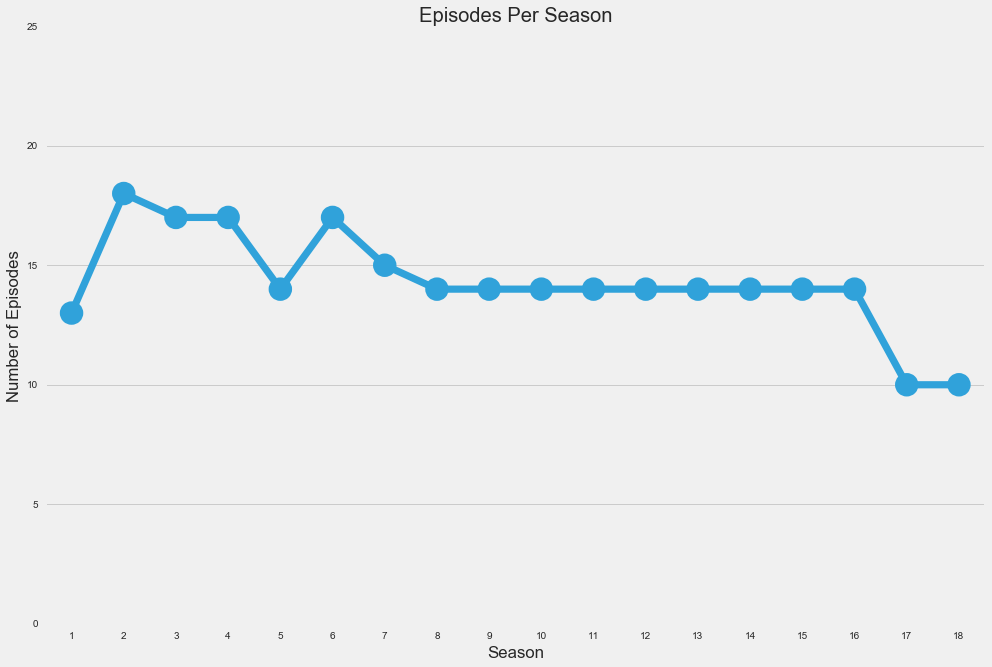

In [49]:
# Exlcuding the 19th season because data in the text analysis is missing so removing it here for consistency
imdb = imdb[imdb.season!=19]

# Using IMDB data because the text data is missing the last epsiode of the 18th season
episodes_per_season = imdb.groupby('season',as_index=False).count()[['episode',"season"]]

sns.pointplot(x="season", y="episode", data=episodes_per_season)
plt.ylim(0,25)
plt.ylabel('Number of Episodes')
plt.xlabel('Season')
plt.title('Episodes Per Season')
plt.savefig('plots/Episodes Per Season')


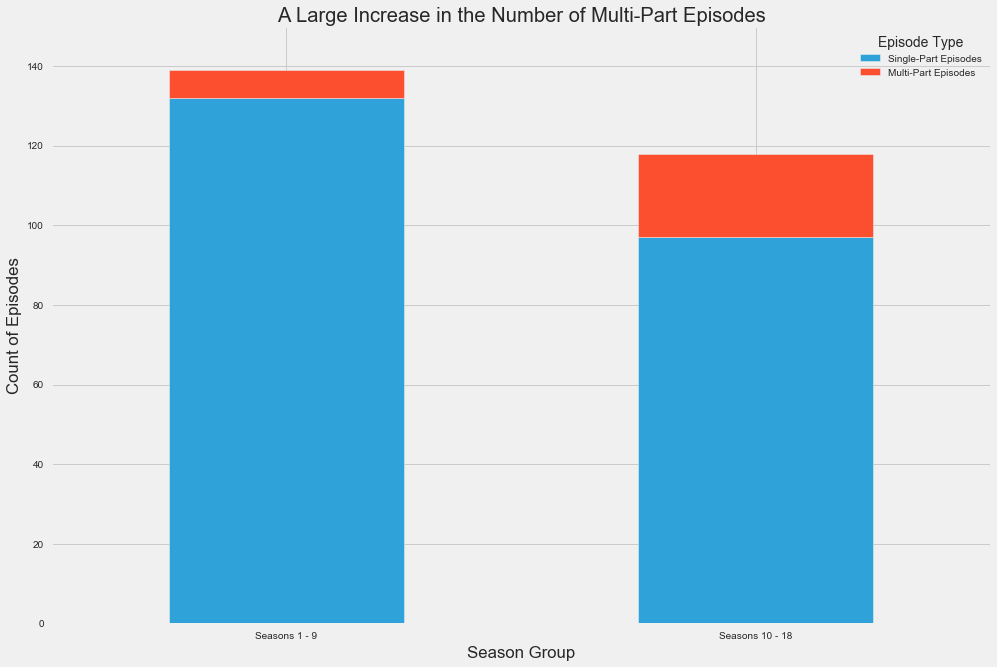

In [50]:
# Make a cleanly named column that divides the series by season
imdb['Season Group'] = np.where(imdb.season>9,"Seasons 10 - 18", "Seasons 1 - 9")

# Make a cleanly named column that labels single-part vs multi-part episodes
imdb['Episode Type'] = np.where(imdb.is_multi_part_episode, "Multi-Part Episodes","Single-Part Episodes")

episode_type_changes =  imdb.groupby(['Season Group','Episode Type'])[['is_multi_part_episode']].count().unstack(level=1)

# Drop unnecessary hierarchical column index
episode_type_changes.columns = episode_type_changes.columns.droplevel()

# Rearrange the order for a cleaner visualization
episode_type_changes = episode_type_changes[['Single-Part Episodes','Multi-Part Episodes']]

episode_type_changes.plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.ylim(0,150)
plt.title('A Large Increase in the Number of Multi-Part Episodes')
plt.ylabel('Count of Episodes')
plt.savefig('plots/Change in Multi-Part Episodes.png')

# IMDB Ratings

In [129]:
imdb.groupby(['Season Group','Episode Type'])[['rating']].mean().unstack(level=1).round(2).to_excel(
    'output_tables/Multi-Part Ratings.xlsx')

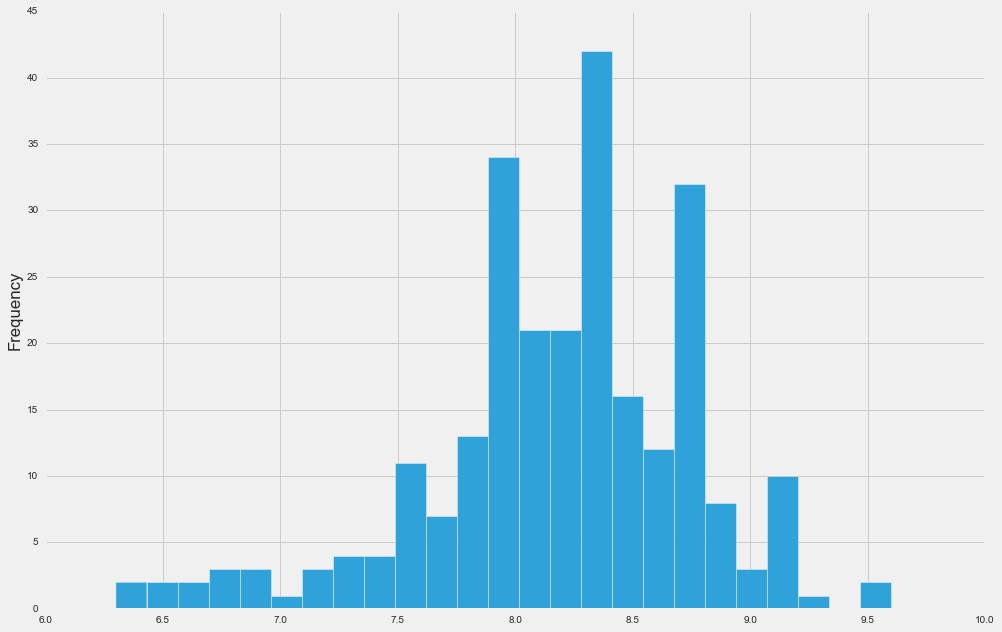

In [122]:
# The distribution of ratings
imdb.rating.plot(kind='hist',bins=25)

In [ ]:
imdb.groupby('season').mean()['rating'].plot()
plt.title('Ratings Over Time')
plt.xlabel('Season')
plt.ylabel('Average Rating')
plt.ylim(5,10)

In [111]:
#calculates the average rating based on the main character of the episode
character_words_per_episode[(character_words_per_episode.character.isin(
            ['Cartman','Butters','Stan','Kyle','Randy','Mr. Garrison','Mrs. Garrison','Jimmy','Chef']))&
            (character_words_per_episode.rank_in_episode==1)].groupby(
            ['character']).mean()[['rating']].round(2).sort_values('rating',ascending=False).to_excel('output_tables/IMDB Character Ratings.xlsx')

,rating
character,
Cartman,8.32
Butters,8.31
Mr. Garrison,8.26
Randy,8.18
Stan,8.18
Mrs. Garrison,8.17
Kyle,8.04
Chef,7.93
Jimmy,7.84


In [664]:
# The number of times a character has had the most words in an episode
character_max_words = character_words_per_episode[character_words_per_episode.had_most_words]

#determine the top 12 characters who were the main character for an episode the most times
character_max_words.groupby(['character']).count()[['had_most_words']].sort_values('had_most_words',ascending=False).head(12).to_excel('output_tables/Most Words.xlsx')

In [665]:
#calculate the number of times a character was the main character for an episode each season
character_max_words = character_max_words.groupby(['character','season','episode_number']).sum()[['had_most_words']].unstack(level=0)
character_max_words.columns = character_max_words.columns.droplevel()
character_max_words.reset_index(inplace=True)


In [658]:
character_max_words = character_max_words[['Cartman','Butters','Stan','Kyle','Randy','Jimmy','Chef','Mr. Garrison','Mrs. Garrison']]

In [660]:
#split the show by the 128th episode (half of 256) and output to excel
character_max_words.groupby(character_max_words_per_season.episode_number>128).count()#.to_excel('output_tables/Max Words After Episode 128.xlsx')

# Explore High Level Changes in Characters Roles

In [30]:
# Assign a value of -1 to all lines from seasons 1-9 and a value of 1 to a line from seasons 10 - 18
sp['series_half'] = np.where((sp.season<= 9 ),-1,1)
sp.series_half.value_counts(normalize=True)

-1    0.609823
 1    0.390177
Name: series_half, dtype: float64

In [39]:
# There are not an even number of lines in each half. This normalizes to correct that.
sp['series_half_normalized'] = sp.series_half.map(lambda x: (2*x*.390177) if x==-1 else 2*(x*.609823))

In [40]:
# The average score gives a sense of relative shift for each character. It can weigh a major shift by a minor character
# higher than a minor shift by a major character. 
sp[sp.character.isin(central_characters(sp,20))].groupby('character').mean(
)[['series_half_normalized']].sort_values('series_half_normalized',ascending=True).round(3)#.plot.box(vert=False)

,series_half_normalized
character,
Chef,-0.680
Mr. Garrison,-0.559
Jimbo,-0.550
Sheila,-0.374
Stan,-0.166
Gerald,-0.119
Kyle,-0.091
Kenny,-0.088
Liane,-0.078


In [41]:
# This weights change by absolute lines. Stan and Kyle had signifcant changes in total (normalized) lines even though 
# they had very low relative changes.
#That is simply because they speak a lot and so a small relative shift for them is still a large absolute change. 
sp[sp.character.isin(central_characters(sp,20))].groupby('character').sum(
)[['series_half_normalized']].sort_values('series_half_normalized').round().astype(int)#.to_excel('output_tables/Character Lines Across Series.xlsx')

,series_half_normalized
character,
Stan,-1270
Kyle,-648
Chef,-624
Mr. Garrison,-560
Jimbo,-306
Sheila,-212
Kenny,-77
Gerald,-75
Liane,-45


# Deep Dive on Characters Roles

 This is a deep dive on the character that had a large shift in their lines as identified above.

In [16]:
sp.groupby(['episode_number','season'],as_index=False).sum().groupby('season').mean()[['number_of_words']].plot()
plt.ylim(0,4000)
plt.title('Average Words per Episode Over Time')
plt.xlabel("Season")
plt.ylabel("Average Total Words per Episode")

KeyError: "['number_of_words'] not in index"

The number of words has fluctuated throughout the show. Therefore, I will use relative percentages of episode dialogue 
instead of absolute word counts when comparing characters across episodes.

In [ ]:
character_words_per_episode = sp.groupby(['episode_number','character','season','rating'],as_index=False)[['number_of_words']].sum()
character_words_per_episode.sort_values(['episode_number','number_of_words'],ascending=False,inplace=True)
character_words_per_episode[['rank_in_episode']]  = character_words_per_episode.groupby('episode_number').rank(method='min',ascending=False)[['number_of_words']]
character_words_per_episode['total_words_in_episode'] = character_words_per_episode.groupby('episode_number')['number_of_words'].transform(sum)
character_words_per_episode['percent_of_words_in_episode'] = (character_words_per_episode.number_of_words /  character_words_per_episode.total_words_in_episode).round(4)*100

In [80]:
def plot_character_dialogue_by_ranking(character_words_per_episode,include_rankings=[],label=''):
    #this filters to only characters that achieved a designated speaking rank in each episode
    included_characters_by_ranking = character_words_per_episode[character_words_per_episode.rank_in_episode.isin(include_rankings)]

    #calculate the perctage of dialogue the desingated character rankings accounted for each episode
    dialogue_per_episode = included_characters_by_ranking.groupby(['episode_number','season'])['percent_of_words_in_episode'].sum()
    
    #reset index level to convert from series to dataframe with season as a variable that can be grouped by 
    dialogue_per_episode = dialogue_per_episode.reset_index(level=1)
    
    dialogue_per_episode.rename(columns={'percent_of_words_in_episode':label},inplace=True)
    
    #summarize each episode into a season
    median_dialogue_per_season = dialogue_per_episode.groupby(['season']).median()[label]
    median_dialogue_per_season.plot(legend=True)
    return None

In [ ]:
character_words_per_episode = sp.groupby(['episode_number','character','season','rating'],as_index=False)[['number_of_words']].sum()
character_words_per_episode.sort_values(['episode_number','number_of_words'],ascending=False,inplace=True)
character_words_per_episode[['rank_in_episode']]  = character_words_per_episode.groupby('episode_number').rank(method='min',ascending=False)[['number_of_words']]
character_words_per_episode['total_words_in_episode'] = character_words_per_episode.groupby('episode_number')['number_of_words'].transform(sum)
character_words_per_episode['percent_of_words_in_episode'] = (character_words_per_episode.number_of_words /  character_words_per_episode.total_words_in_episode).round(4)*100

In [ ]:
character_words_per_episode = sp.groupby(['episode_number','character','season','rating'],as_index=False)[['number_of_words']].sum()
character_words_per_episode.sort_values(['episode_number','number_of_words'],ascending=False,inplace=True)
character_words_per_episode[['rank_in_episode']]  = character_words_per_episode.groupby('episode_number').rank(method='min',ascending=False)[['number_of_words']]
character_words_per_episode['total_words_in_episode'] = character_words_per_episode.groupby('episode_number')['number_of_words'].transform(sum)
character_words_per_episode['percent_of_words_in_episode'] = (character_words_per_episode.number_of_words /  character_words_per_episode.total_words_in_episode).round(4)*100

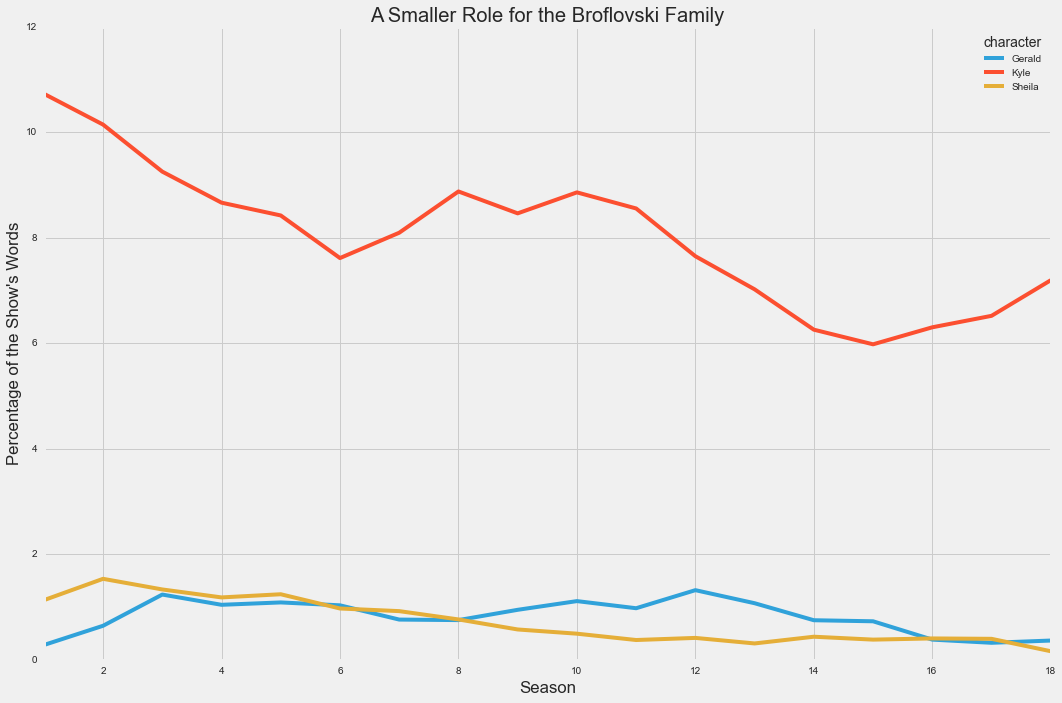

In [122]:
character_lines_by_season = sp[sp.character.str.contains('^kyle$|^gerald$|^sheila$',case=False)].groupby(['character','season']).sum()['number_of_words'].unstack(level=0).fillna(0)
character_lines_by_season['words_in_season'] = sp.groupby('season')[['number_of_words']].sum()
character_lines_by_season = character_lines_by_season.div(character_lines_by_season.words_in_season,axis=0).round(4) * 100
character_lines_by_season.drop('words_in_season',axis=1,inplace=True)
character_lines_by_season.rolling(4,min_periods=1).mean().plot(kind='line')

plt.title('A Smaller Role for the Broflovski Family')
plt.xlabel('Season')
plt.ylabel('Percentage of the Show\'s Words')
plt.tight_layout()
plt.savefig('plots/Broflovski.png')

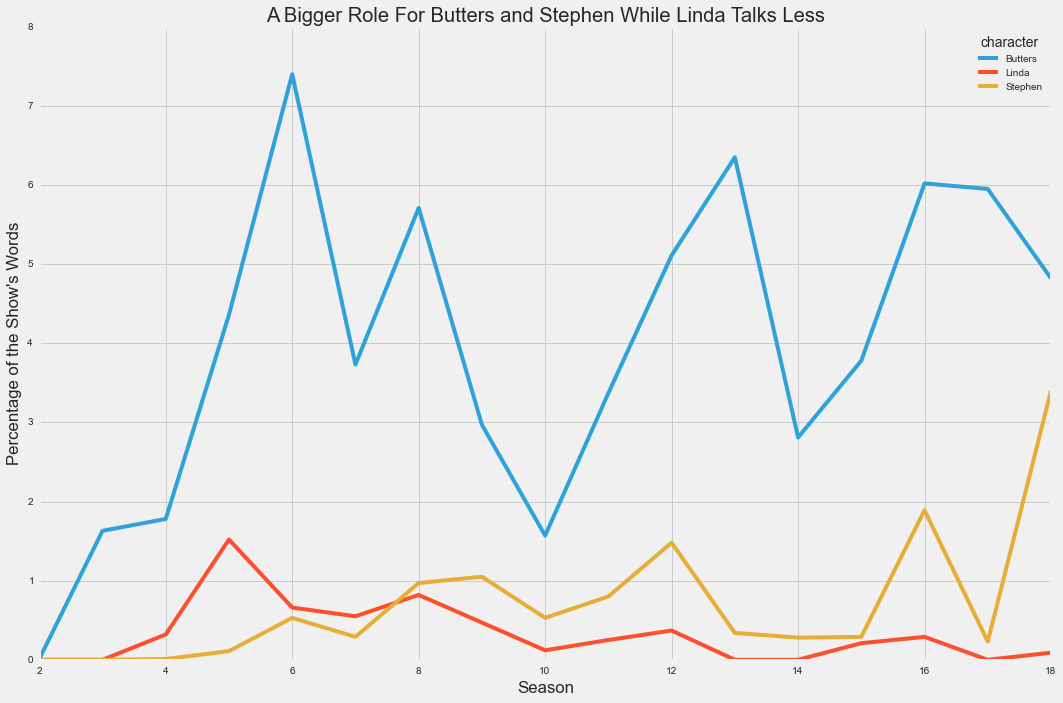

In [670]:
character_lines_by_season = sp[sp.character.str.contains('^butters$|^stephen$|^linda$',case=False)].groupby(['character','season']).sum()['number_of_words'].unstack(level=0).fillna(0)
character_lines_by_season['words_in_season'] = sp.groupby('season')[['number_of_words']].sum()
character_lines_by_season = character_lines_by_season.div(character_lines_by_season.words_in_season,axis=0).round(4) * 100
character_lines_by_season.drop('words_in_season',axis=1,inplace=True)
character_lines_by_season.rolling(4,min_periods=1).mean().plot(kind='line')

plt.title('A Bigger Role For Butters and Stephen While Linda Talks Less')
plt.xlabel('Season')
plt.ylabel('Percentage of the Show\'s Words')
plt.tight_layout()
plt.savefig('plots/Butters.png')

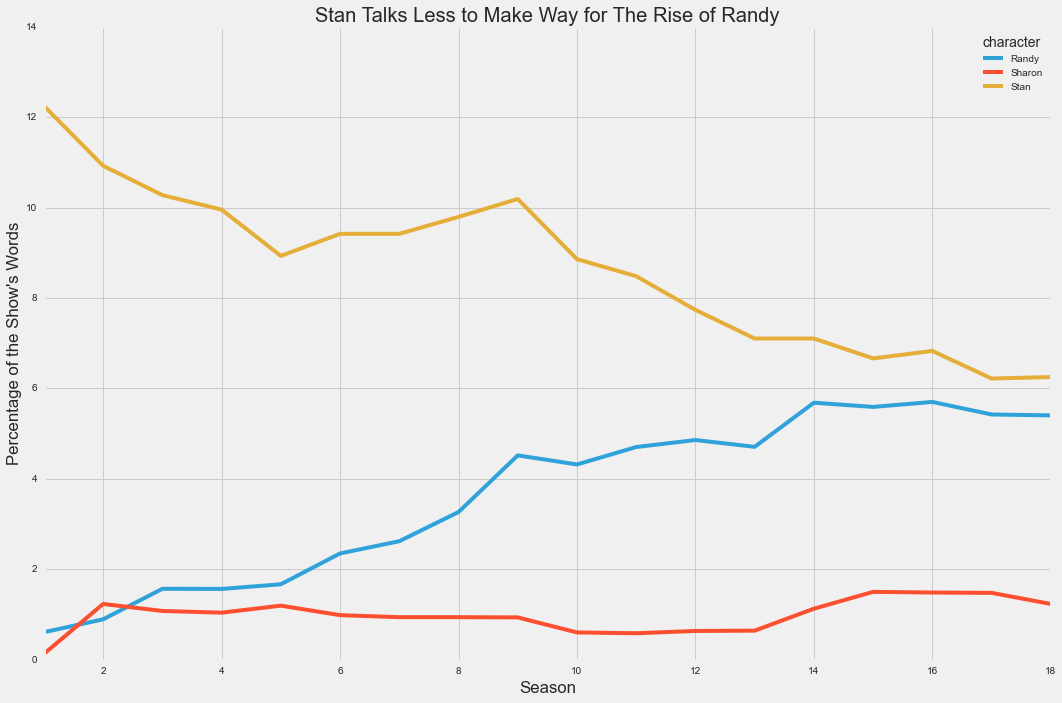

In [123]:
character_lines_by_season = sp[sp.character.str.contains('^randy$|^stan$|^sharon$',case=False)].groupby(['character','season']).sum()['number_of_words'].unstack(level=0).fillna(0)
character_lines_by_season['words_in_season'] = sp.groupby('season')[['number_of_words']].sum()
character_lines_by_season = character_lines_by_season.div(character_lines_by_season.words_in_season,axis=0).round(4) * 100
character_lines_by_season.drop('words_in_season',axis=1,inplace=True)
character_lines_by_season.rolling(4,min_periods=1).mean().plot(kind='line')
#plt.xticks(range(1,19))
plt.title('Stan Talks Less to Make Way for The Rise of Randy')
plt.xlabel('Season')
plt.ylabel('Percentage of the Show\'s Words')
plt.tight_layout()
plt.savefig('plots/Marsh Family.png')

In [85]:
# character_lines_by_season = sp[sp.character.str.contains('^jimmy$',case=False)].groupby(['character','season']).sum()['number_of_words'].unstack(level=0).fillna(0)
# character_lines_by_season['words_in_season'] = sp.groupby('season')[['number_of_words']].sum()
# character_lines_by_season = character_lines_by_season.div(character_lines_by_season.words_in_season,axis=0).round(4) * 100
# character_lines_by_season.drop('words_in_season',axis=1,inplace=True)
# character_lines_by_season.rolling(4,min_periods=1).mean().plot(kind='line')
# plt.title('Jimmy')
# plt.ylim(0,10)
# plt.xlabel('Season')
# plt.ylabel('Percentage of the Show\'s Words')
# plt.tight_layout()
# plt.savefig('plots/Jimmy.png')

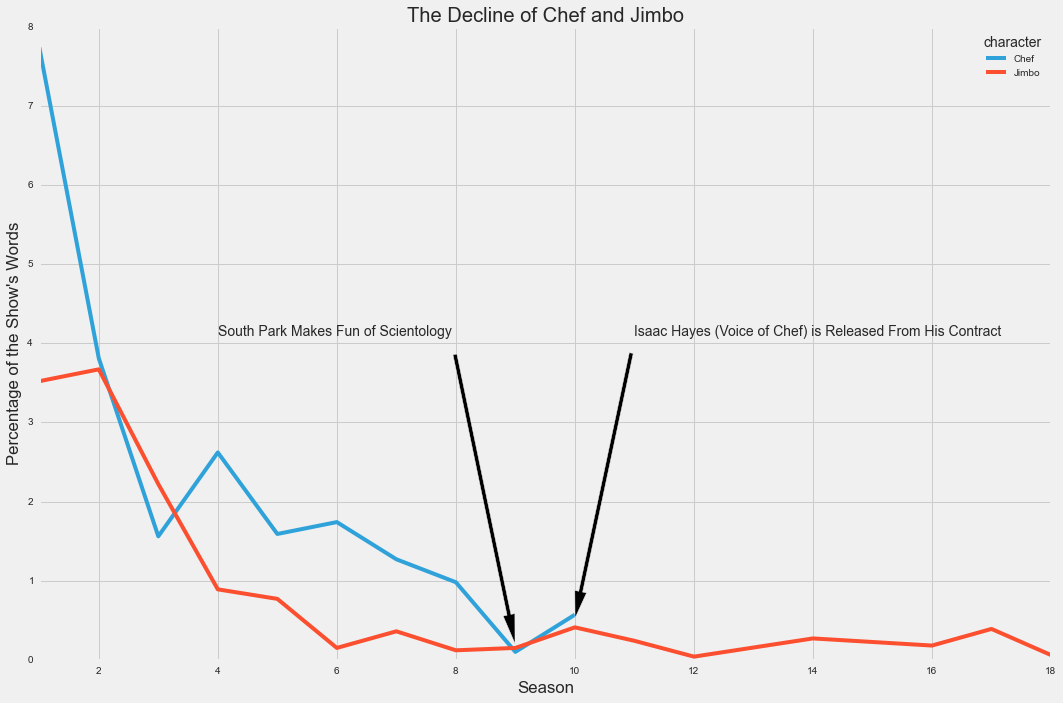

In [614]:
character_lines_by_season = sp[sp.character.str.contains('^chef$|^jimbo$',case=False)].groupby(['character','season']).sum()['number_of_words'].unstack(level=0)#.fillna(0)
character_lines_by_season['words_in_season'] = sp.groupby('season')[['number_of_words']].sum()
character_lines_by_season = character_lines_by_season.div(character_lines_by_season.words_in_season,axis=0).round(4) * 100
character_lines_by_season.drop('words_in_season',axis=1,inplace=True)
character_lines_by_season.plot(kind='line')

plt.title('The Decline of Chef and Jimbo')
plt.xlabel('Season')
plt.ylabel('Percentage of the Show\'s Words')
plt.annotate('South Park Makes Fun of Scientology',xy=(9.05,0), xytext=(4, 4.1), arrowprops=dict(facecolor='black',shrink=0.05))
plt.annotate('Isaac Hayes (Voice of Chef) is Released From His Contract',xy=(9.95,.34), xytext=(11, 4.1), arrowprops=dict(facecolor='black',shrink=0.05))
plt.tight_layout()
plt.savefig('plots/Chef Jimbo.png')

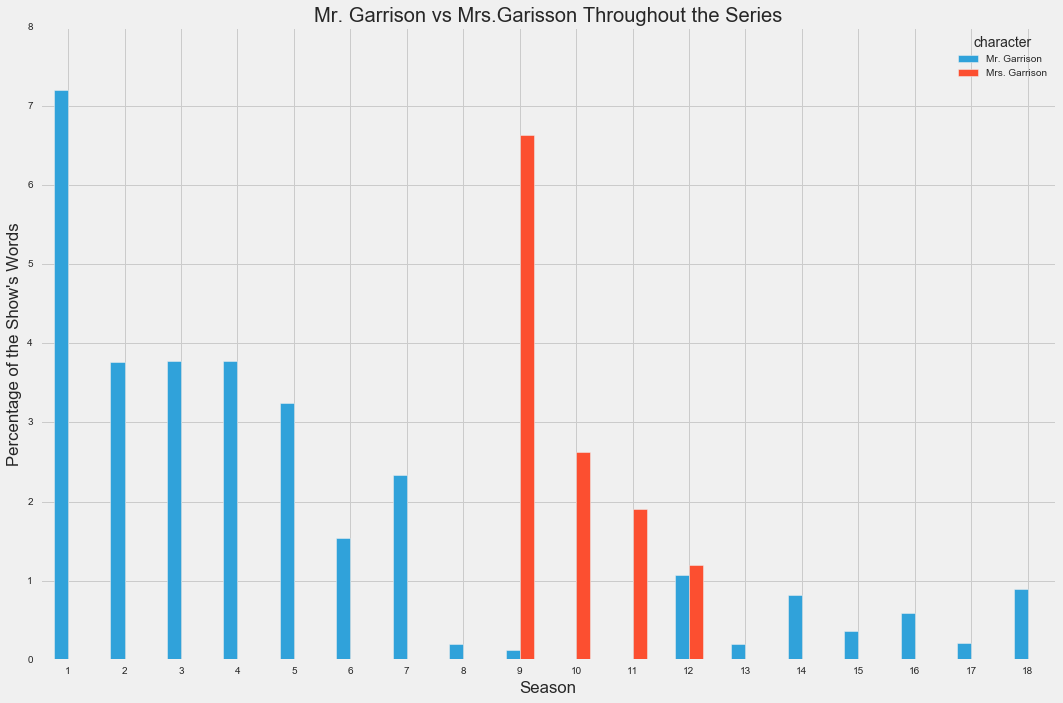

In [86]:
character_lines_by_season = sp[sp.character.str.contains('(^mr(\.)? garrison)$|(mrs(\.)? garrison$)',case=False)].groupby(['character','season']).sum()['number_of_words'].unstack(level=0).fillna(0)
character_lines_by_season['words_in_season'] = sp.groupby('season')[['number_of_words']].sum()
character_lines_by_season = character_lines_by_season.div(character_lines_by_season.words_in_season,axis=0).round(4) * 100
character_lines_by_season.drop('words_in_season',axis=1,inplace=True)
character_lines_by_season.plot(kind='bar')
plt.xticks(range(0,18),rotation=0)
plt.title('Mr. Garrison vs Mrs.Garisson Throughout the Series')
plt.xlabel('Season')
plt.ylabel('Percentage of the Show\'s Words')
plt.tight_layout()
plt.savefig('plots/Garrison.png')

In [87]:
sp['president']= sp.line.str.contains('president',case=False)
sp['politics']= sp.line.str.contains('clinton|george bush|obama|mccain|palin|al gore|vote|romney|kerry',case=False)

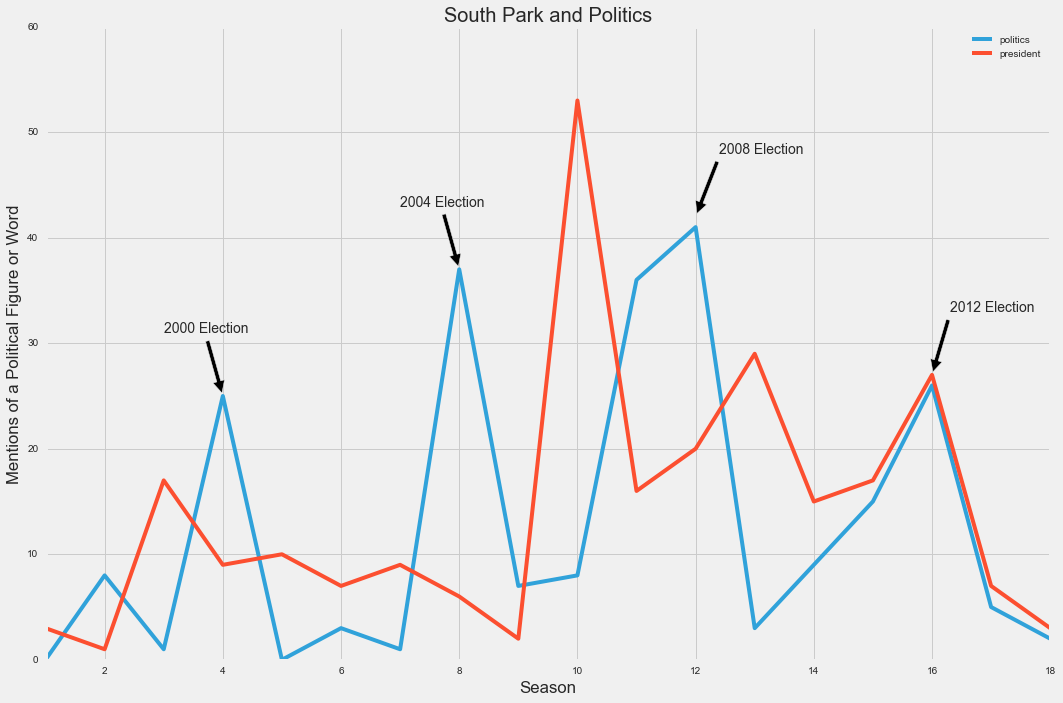

In [88]:
sp.groupby('season')[['politics','president']].sum().plot()
plt.annotate('2000 Election',xy=(4,25), xytext=(3, 31), arrowprops=dict(facecolor='black',shrink=0.05))
plt.annotate('2004 Election',xy=(8,37), xytext=(7, 43), arrowprops=dict(facecolor='black',shrink=0.05))
plt.annotate('2008 Election',xy=(12,42), xytext=(12.4, 48), arrowprops=dict(facecolor='black',shrink=0.05))
plt.annotate('2012 Election',xy=(16,27), xytext=(16.3, 33), arrowprops=dict(facecolor='black',shrink=0.05))
plt.xlabel('Season')
plt.ylabel('Mentions of a Political Figure or Word')
plt.title('South Park and Politics')
plt.tight_layout()
plt.savefig('plots/South Park and Politics.png')

In [ ]:
character_percent_words_of_episode = sp.groupby(['episode_number','season','character']).sum()['number_of_words'].reset_index()
character_percent_words_of_episode['words_in_episode'] = sp.groupby('episode_number')[['number_of_words']].transform('sum')
character_percent_words_of_episode['percent_of_words'] = (character_percent_words_of_episode.number_of_words/ character_percent_words_of_episode.words_in_episode).round(4)*100
character_percent_words_of_episode.reset_index(inplace=True)
def plot_character_count_above_threshold(character_percent_words_of_episode,percentage_threshold):
    #determine the legend name 
    legend_name = 'Characters Who Spoke More Than %s%% of An Episode'% percentage_threshold
    
    #filter based on the threshold
    character_percent_words_of_episode = character_percent_words_of_episode[character_percent_words_of_episode.percent_of_words>percentage_threshold]
    
    #aggregate the count of characters above the threshold for each episode
    character_count_per_episode = character_percent_words_of_episode.groupby(['episode_number','season'],as_index=False).count()
    
    #change the name of the column to be plotted to the desired legend name
    character_count_per_episode.rename(columns={'number_of_words':legend_name},inplace=True)
    
    #calculate the median count of character for each season
    median_character_count_per_season = character_count_per_episode.groupby('season')[legend_name].median()
    
    #plot it                                            
    median_character_count_per_season.plot(legend=True)
    return None

plot_character_count_above_threshold(character_percent_words_of_episode,percentage_threshold=1)
plot_character_count_above_threshold(character_percent_words_of_episode,percentage_threshold=5)
plot_character_count_above_threshold(character_percent_words_of_episode,percentage_threshold=10)

plt.ylim(0,25)
plt.yticks(range(0,25))
plt.title('Characters Involved in Plot Over Time')
plt.ylabel('Median Number of Characters')
plt.xlabel('Season')

# Attempt to use word2vec model

In [84]:

from gensim.models import word2vec

In [85]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 10   # Minimum word count                        
# num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words


In [86]:
sp.clean_text = sp.clean_text.str.lower().str.strip()
posts_corpus =  sp.line.str.lower().map(lambda x: x.split()).tolist()
# posts_corpus =' '.join(sp.clean_text)


In [91]:
corpus = '\n '.join(sp.line)

In [95]:
import nltk.data
nltk.download()   

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

KeyboardInterrupt: 

In [96]:
sentences = corpus.split('\n')

In [97]:
sentences

[u"School day, school day, teacher's golden ru...",
 u'',
 u" Ah, damn it! My little brother's trying to follow me to school again.",
 u'',
 u' Zeeponanner.',
 u'',
 u" Ike, you can't come to school with me. ",
 u'',
 u' Yeah, go home you little dildo.',
 u'',
 u" Dude, don't call my brother a dildo!",
 u'',
 u" What's a dildo?",
 u'',
 u" Well, I don't know...  and I'll bet Cartman doesn't know either!",
 u'',
 u' I know what it means!',
 u'',
 u' Well, what?',
 u'',
 u" I'm not telling you.",
 u'',
 u" What's a dildo, Kenny?",
 u'',
 u" (It's a giant stick that goes inside the mom's vagina) ",
 u'',
 u" He-yeah, that's what Kyle's little brother is all right!  Ow! ",
 u'',
 u' Dude, that kicks ass!',
 u'',
 u' Yeah, check this one out. Ready, Ike? Kick the baby!',
 u'',
 u" Don't kick the baby.",
 u'',
 u' Kick the baby. ',
 u'',
 u" Whoa, Cartman! Looks like you didn't get much sleep last night.",
 u'',
 u" That's 'cause I was having these... bogus nightmares.",
 u'',
 u' Really? Wh

In [87]:
a=  word2vec.Word2Vec(posts_corpus,
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

KeyboardInterrupt: 

In [71]:
len(a.vocab)

5901

In [68]:
a.most_similar("ginger")

[(u'ignorant', 0.8353090286254883),
 (u'smurfs', 0.8293266892433167),
 (u'guy,', 0.8205006122589111),
 (u'voting', 0.818790853023529),
 (u'dolphins', 0.8135181665420532),
 (u'decide', 0.8043432831764221),
 (u'leprechauns', 0.8010463714599609),
 (u'violence.', 0.7990833520889282),
 (u'emos', 0.7987491488456726),
 (u'joke,', 0.7975754141807556)]

In [61]:
len(posts_corpus)

70878

# This didn't make it to the main post because there weren't obvious patterns. 

In [82]:
# copy of south park dataframe where characters are  into buckets ###########
sp_main_characters = sp.copy()

#bucket the 4 boys together
sp_main_characters.character = sp_main_characters.character.str.replace('Stan|Cartman|Kenny|Kyle','The Boys',case=False)

n_supporting_characters = 21
central_characters_lst = central_characters(sp_main_characters,n_supporting_characters+1)
try:
    central_characters_lst.remove('Announcer')
    n_supporting_characters = n_supporting_characters - 1
except ValueError:
    pass

sp_main_characters.ix[sp_main_characters.character.isin(central_characters_lst[1:]),
                     ['character']] = "Top %s Supporting Characters" % n_supporting_characters

#bucket all remaining characters together as "Other Character"
sp_main_characters.ix[~((sp_main_characters.character.isin(central_characters_lst[:1]))|
                      (sp_main_characters.character=="Top %s Supporting Characters" % n_supporting_characters)),
                     ['character']] = "Other Characters"

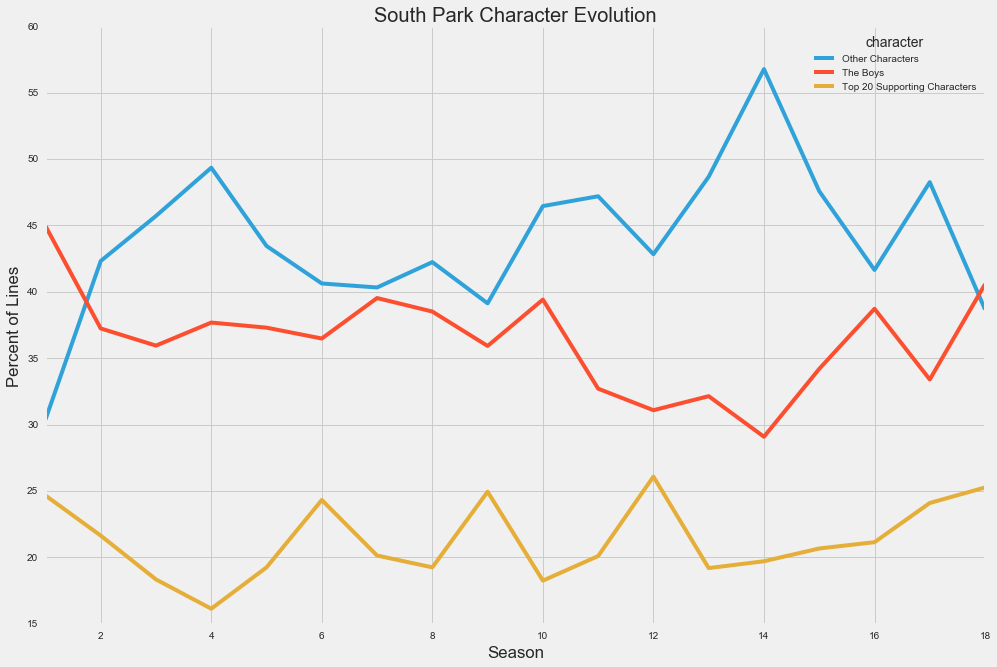

In [83]:
#calculate the % of lines per epsiode for each character group
lines_per_epsiode = sp_main_characters.groupby(['episode_number','season','character']).count()[['line']].unstack(level=2)
lines_per_epsiode.columns = lines_per_epsiode.columns.droplevel()
lines_per_epsiode = lines_per_epsiode.div(lines_per_epsiode.sum(axis=1), axis=0).round(4)*100
lines_per_epsiode.reset_index().drop('episode_number',axis=1).groupby(['season']).mean().fillna(0).rolling(1).mean().plot()
plt.title('South Park Character Evolution')
plt.xlabel('Season')
plt.ylabel('Percent of Lines')